In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.colors import Normalize, ListedColormap
import numpy as np
from matplotlib import cm

### Inputs

In [2]:
# -------------------------------
# Load data
skill_scores_long = pd.read_csv('./camels-spat/outputs/nse_no_monthly_skill_scores.csv')
output_dir = './camels-spat/plots/'
plot_prefix = 'nse'

# -------------------------------
# Settings
period = 'calibration'

# Specify the benchmarks and metrics to calculate
plots = [
    # Streamflow benchmarks
    "bm_mean_flow",
    "bm_median_flow",
    # "bm_annual_mean_flow",  NaN
    # "bm_annual_median_flow",  NaN
    "bm_monthly_mean_flow",
    "bm_monthly_median_flow",
    "bm_daily_mean_flow",
    "bm_daily_median_flow",

    # Long-term rainfall-runoff ratio benchmarks
    "bm_rainfall_runoff_ratio_to_all",
    "bm_rainfall_runoff_ratio_to_annual",
    "bm_rainfall_runoff_ratio_to_monthly",
    "bm_rainfall_runoff_ratio_to_daily",
    "bm_rainfall_runoff_ratio_to_timestep",

    # Short-term rainfall-runoff ratio benchmarks
    # "bm_monthly_rainfall_runoff_ratio_to_monthly",
    # "bm_monthly_rainfall_runoff_ratio_to_daily",
    # "bm_monthly_rainfall_runoff_ratio_to_timestep",

    # Schaefli & Gupta (2007) benchmarks
    "bm_scaled_precipitation_benchmark",  # equivalent to "rainfall_runoff_ratio_to_daily"
    "bm_adjusted_precipitation_benchmark",
    "bm_adjusted_smoothed_precipitation_benchmark",

    # Summary 
    'highest',
    'lowest'
     ]


### Pre-Processing

In [3]:
# Filter by period
df_period = skill_scores_long[skill_scores_long['period'] == period]

# Function to get value + corresponding benchmark
def get_extreme(df, agg_func='max'):
    if agg_func == 'max':
        idx = df['skill_score'].idxmax()
    else:
        idx = df['skill_score'].idxmin()
    return pd.Series({
        'value': df.loc[idx, 'skill_score'],
        'benchmark': df.loc[idx, 'benchmark']
    })

# Compute highest and lowest per catchment
catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(
    lambda x: pd.concat([
        get_extreme(x, 'max').rename(lambda k: f'highest_{k}'),
        get_extreme(x, 'min').rename(lambda k: f'lowest_{k}')
    ])
).reset_index()

# Merge lat/lon
latlon = df_period[['catchment','latitude','longitude']].drop_duplicates()
catchment_stats = catchment_extremes.merge(latlon, on='catchment', how='left')

/tmp/ipykernel_2860070/873659307.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catchment_extremes = df_period.groupby('catchment', group_keys=False).apply(


In [4]:
# Prepare data for plotting
plot_dfs = {}
for benchmark in plots:
    if benchmark == 'highest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','highest_value']].rename(columns={'highest_value':'skill_score'})
    elif benchmark == 'lowest':
        plot_dfs[benchmark] = catchment_stats[['catchment','latitude','longitude','lowest_value']].rename(columns={'lowest_value':'skill_score'})
    else:
        plot_dfs[benchmark] = df_period[df_period['benchmark'] == benchmark][['catchment','latitude','longitude','skill_score']]

# Remove rows with NaN in lat/lon or skill_score
#plot_dfs = plot_dfs.dropna(subset=['longitude', 'latitude', 'skill_score'])


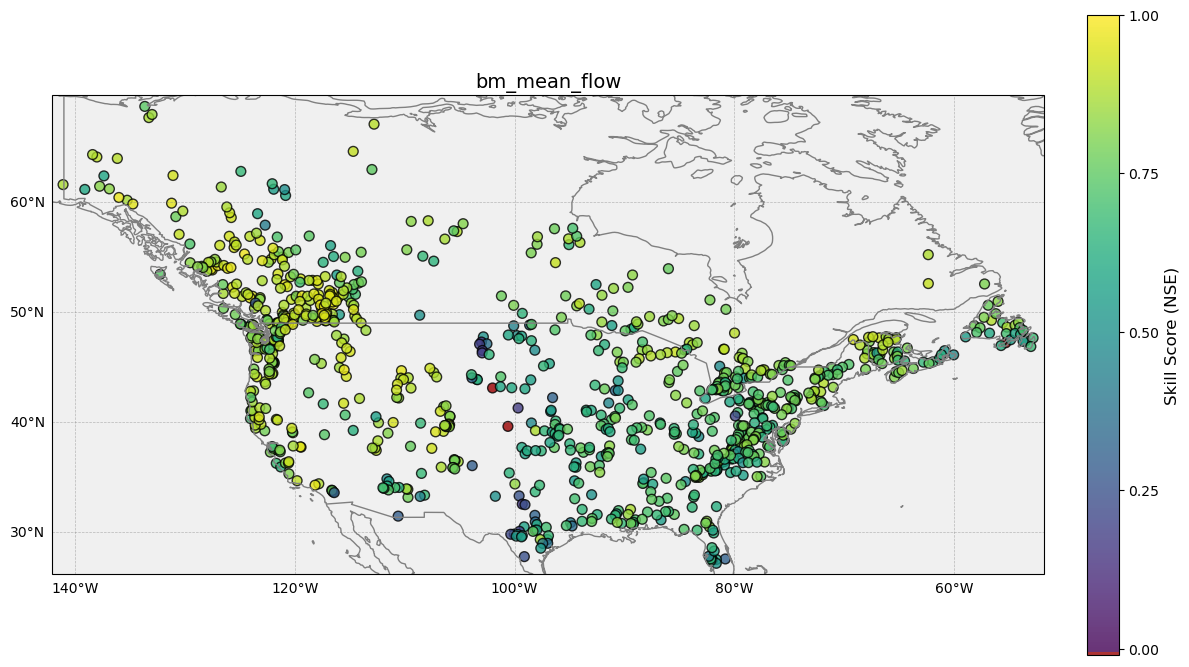

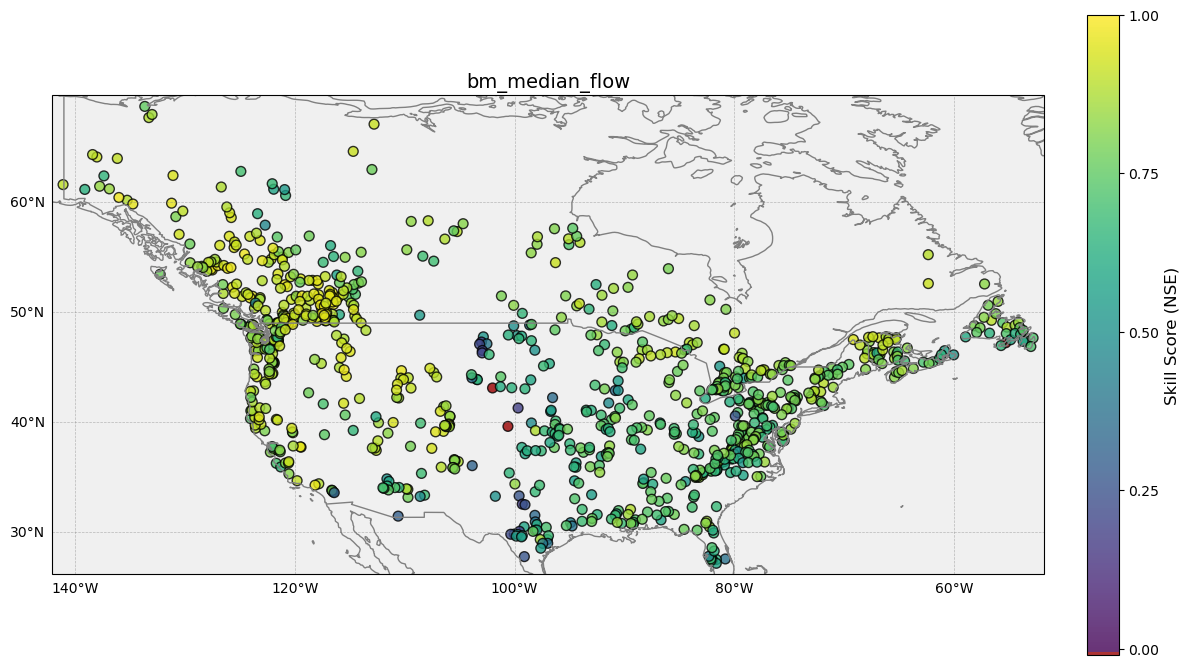

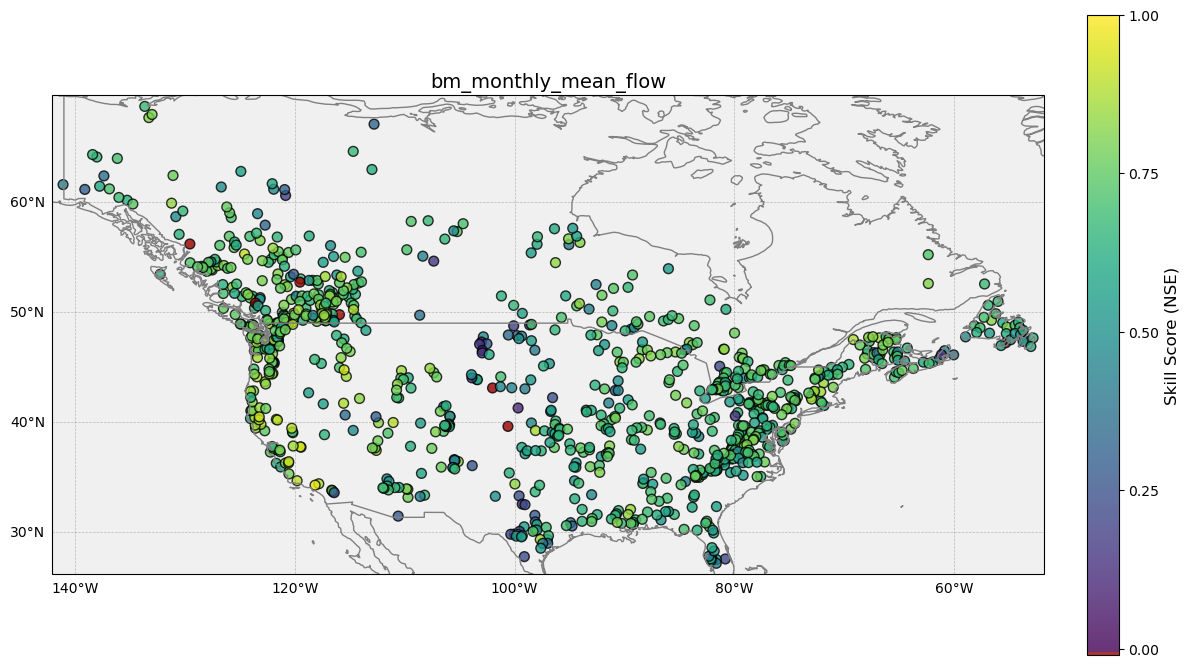

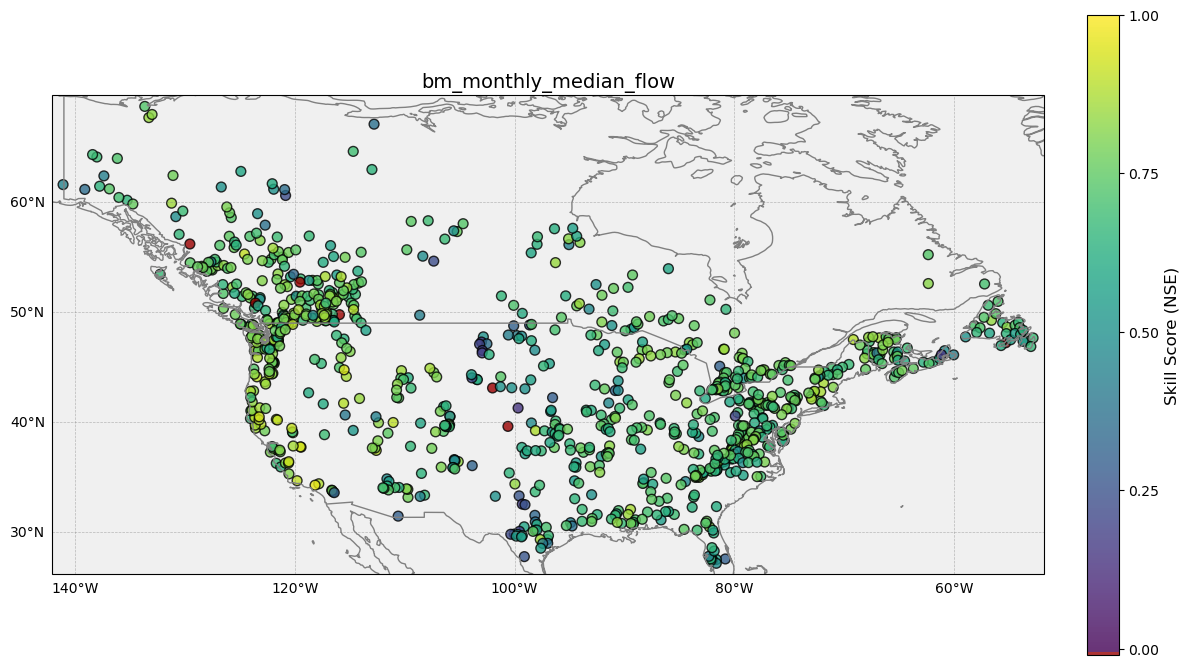

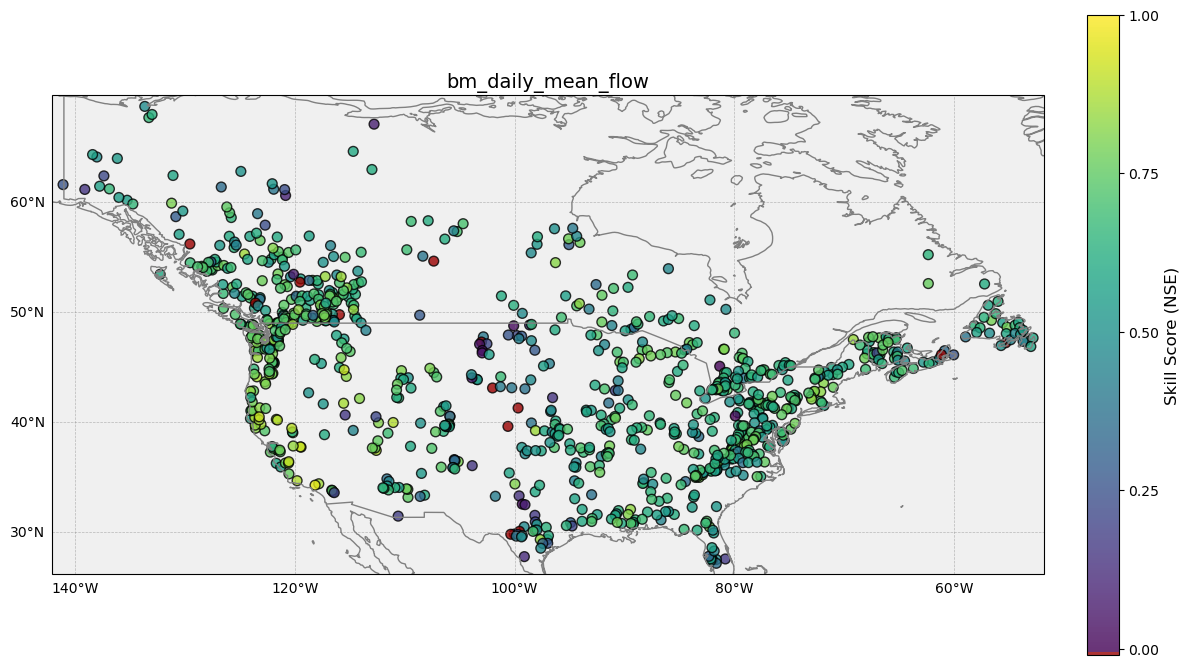

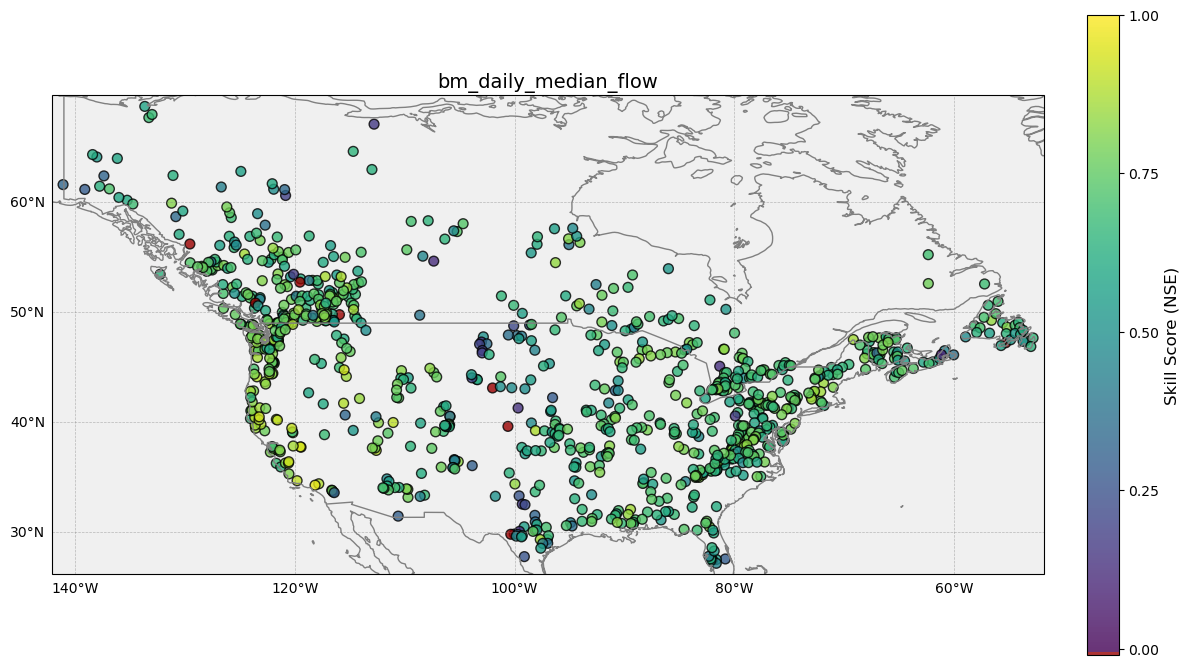

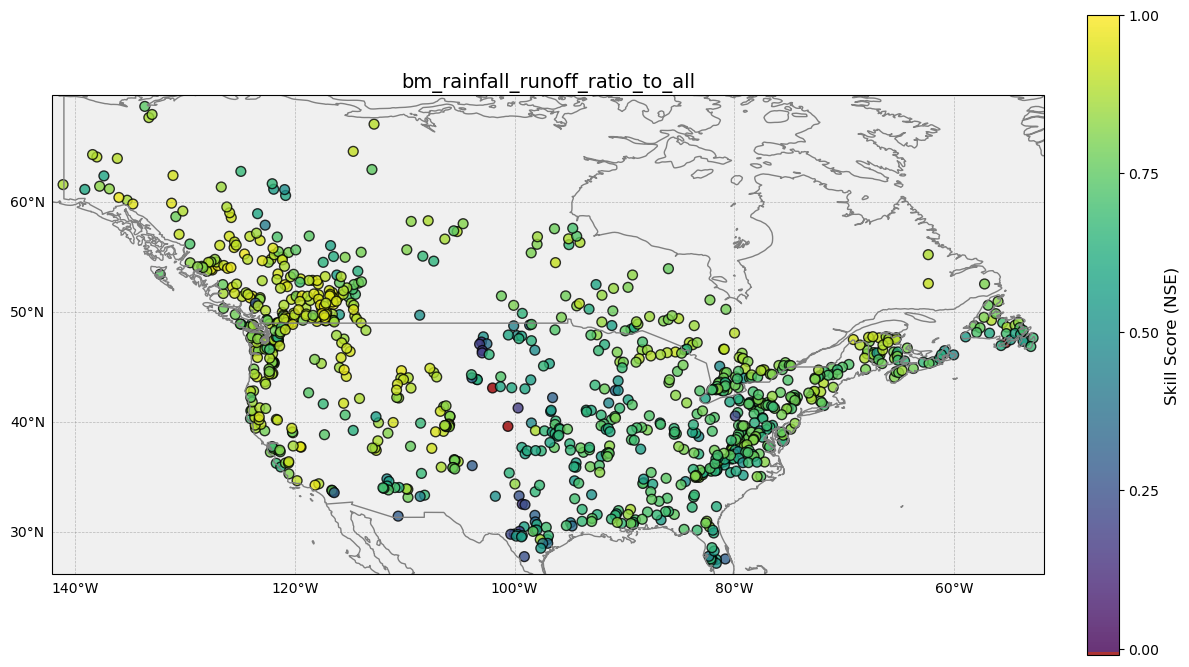

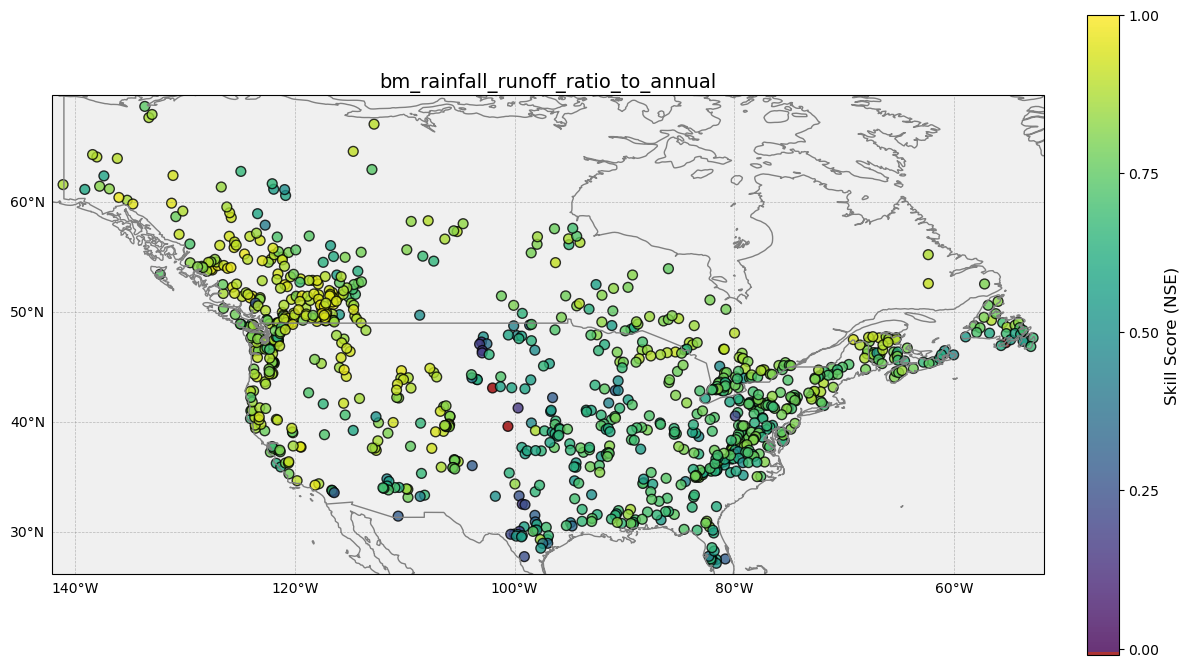

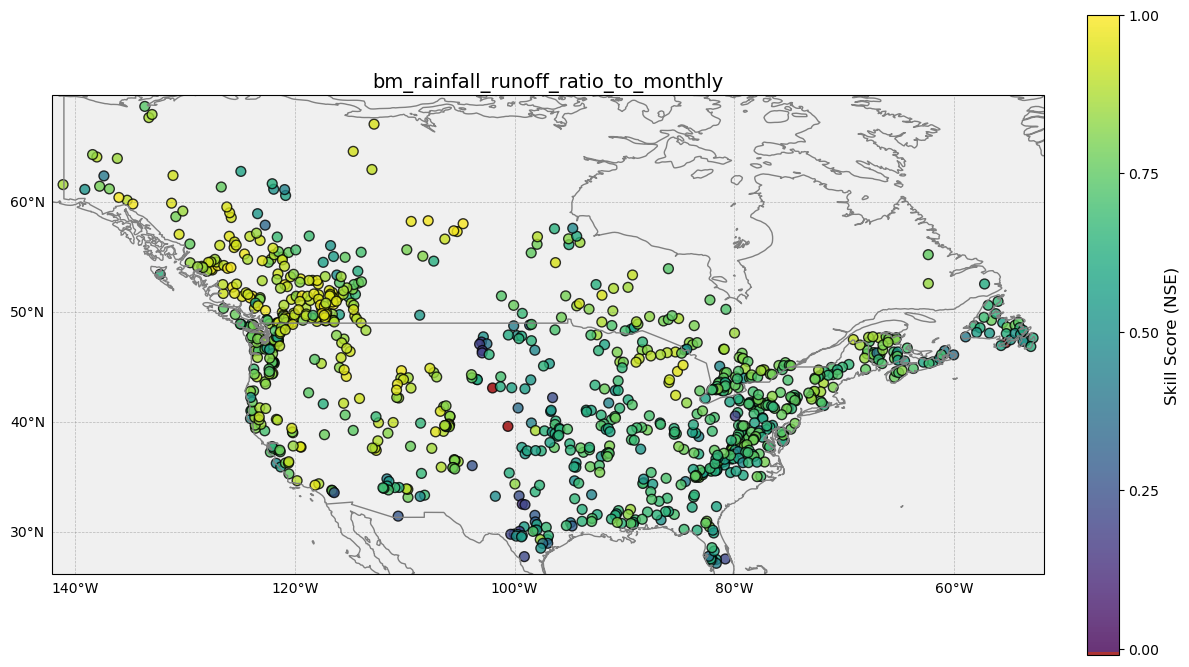

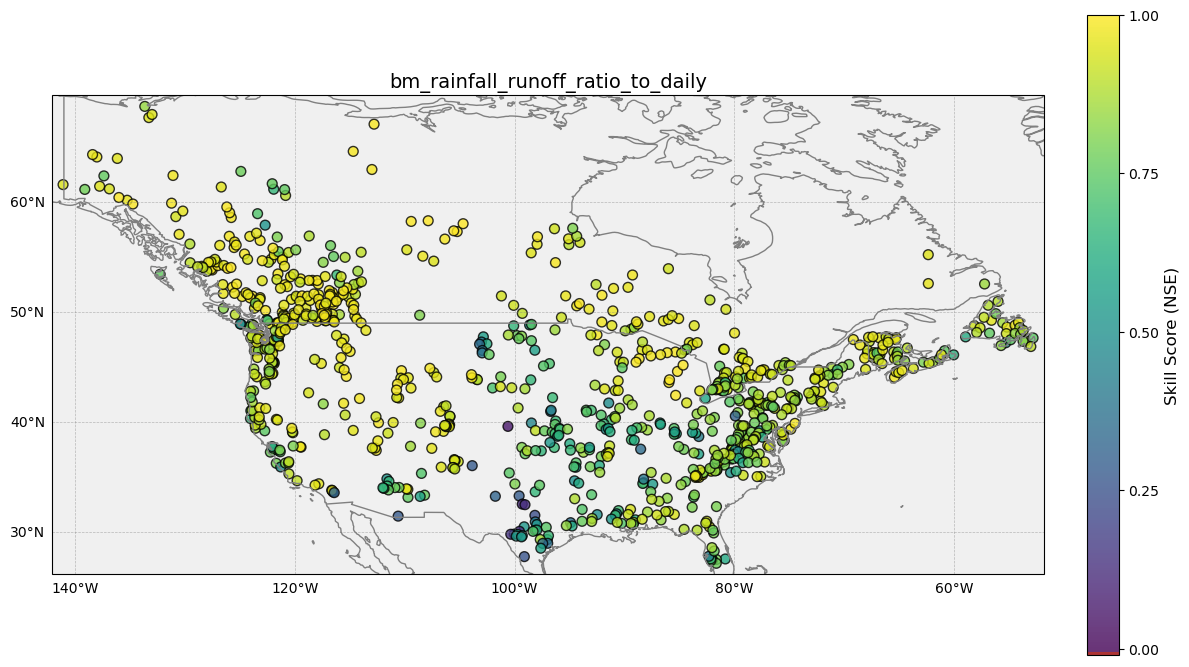

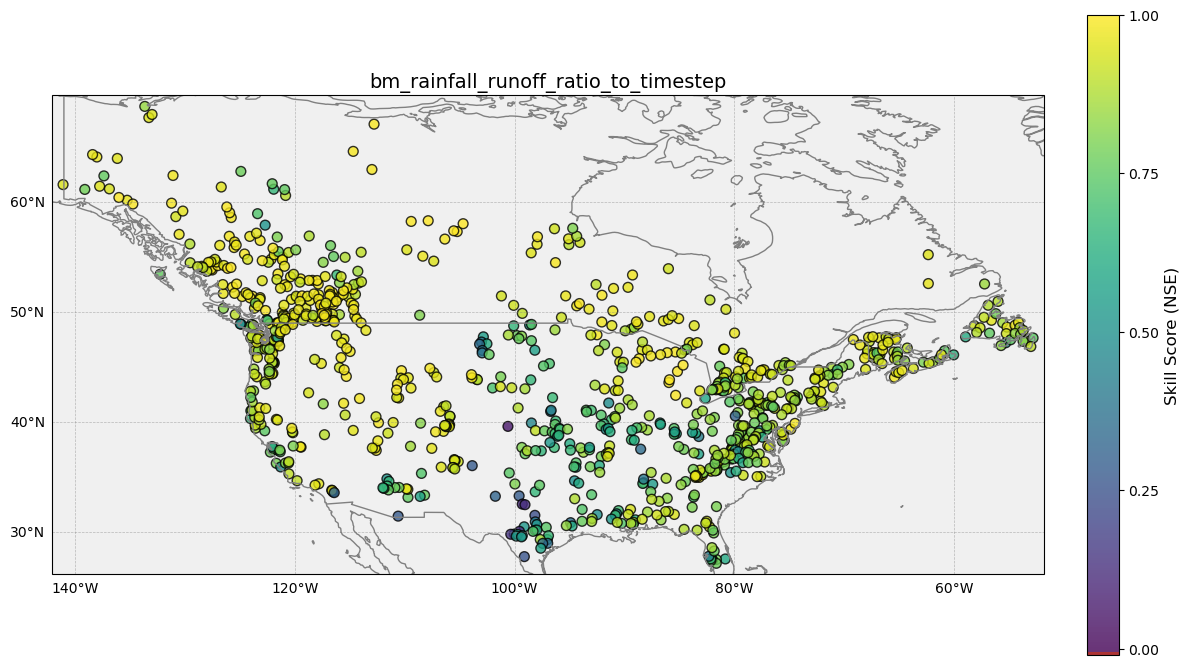

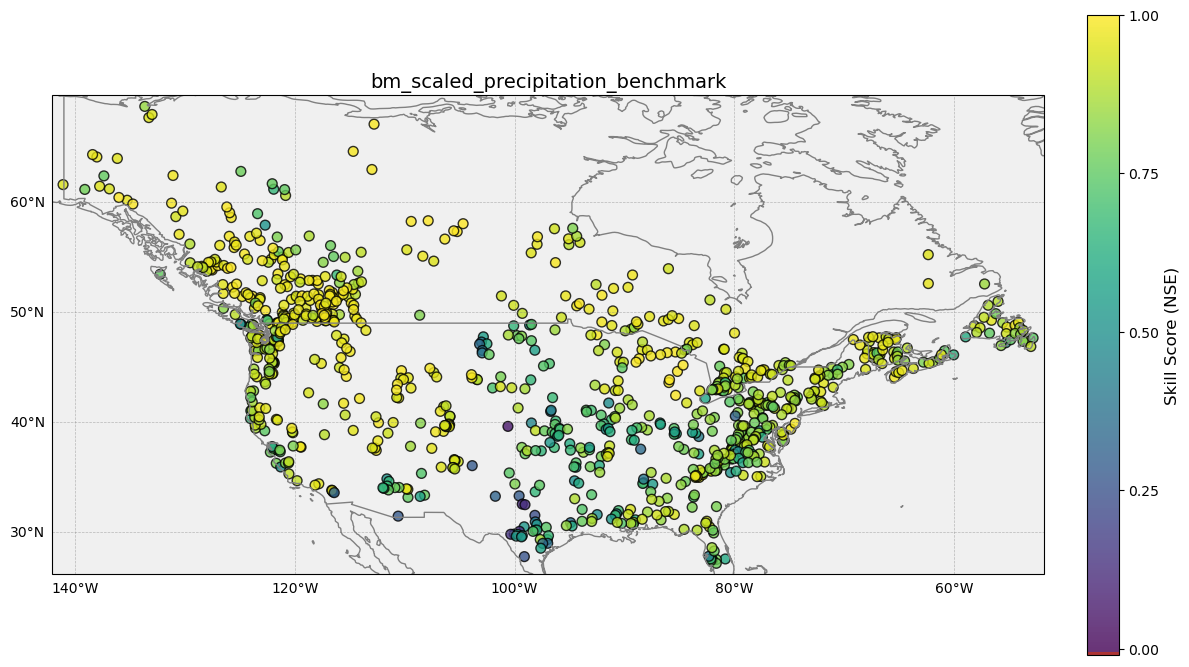

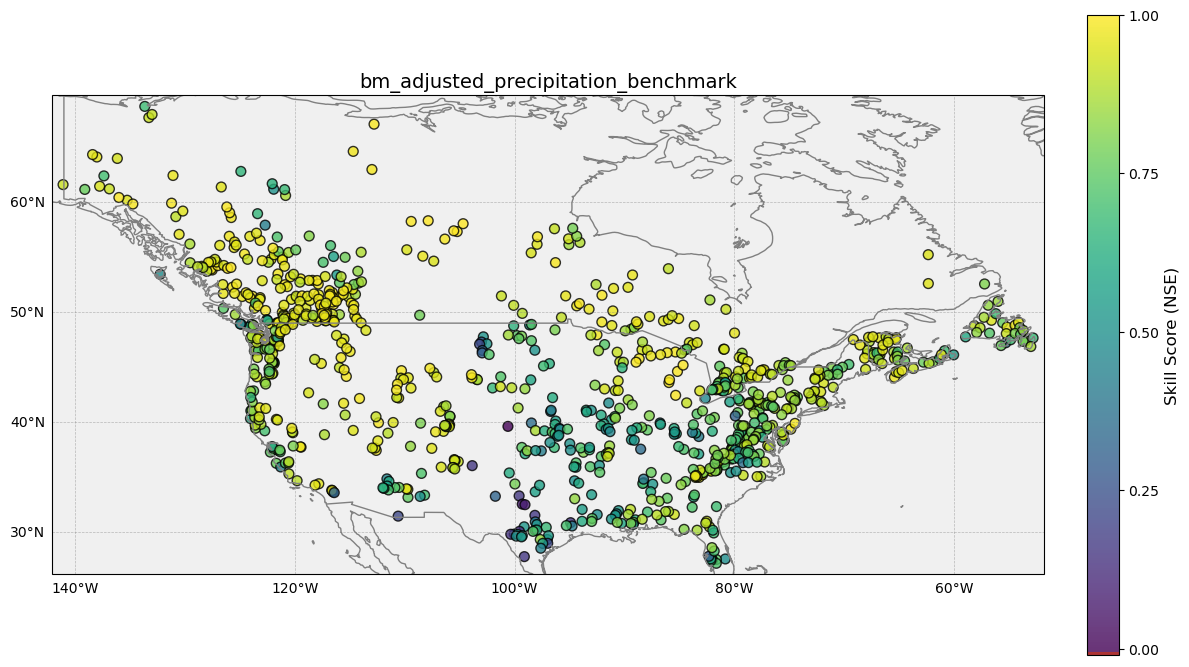

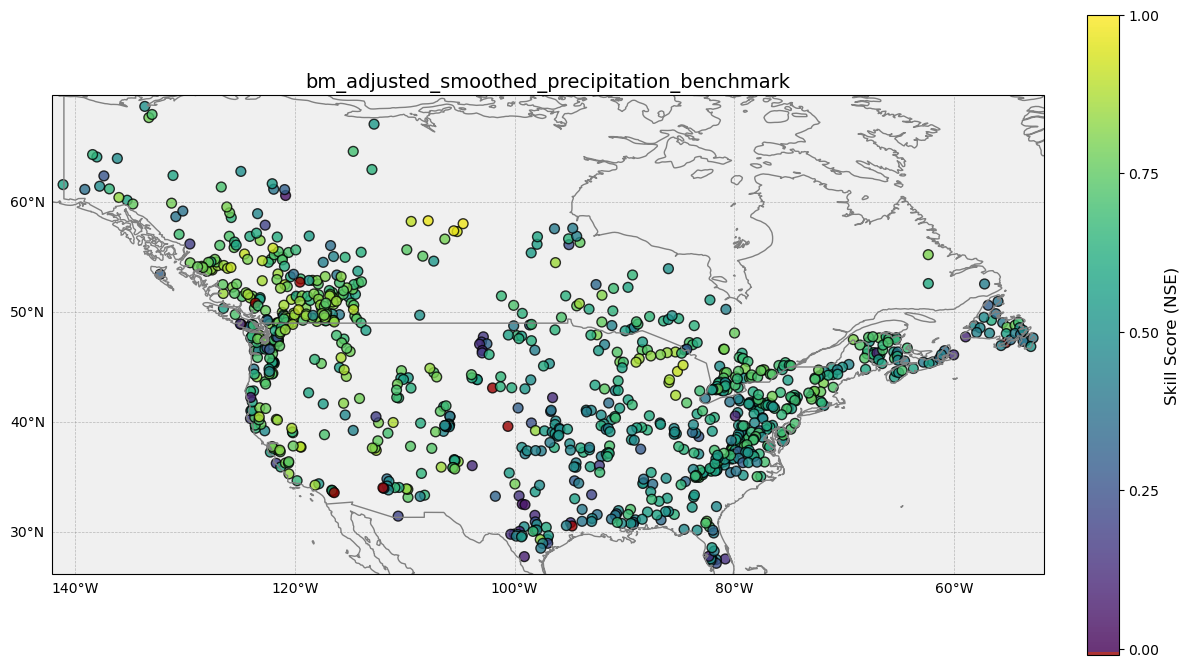

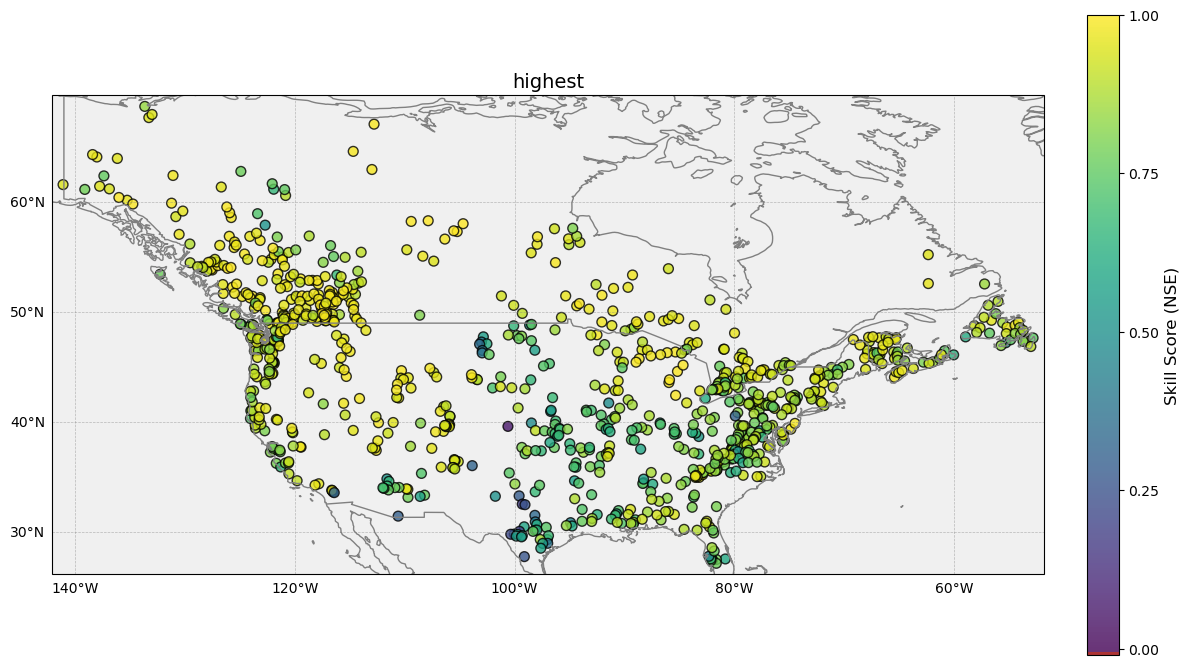

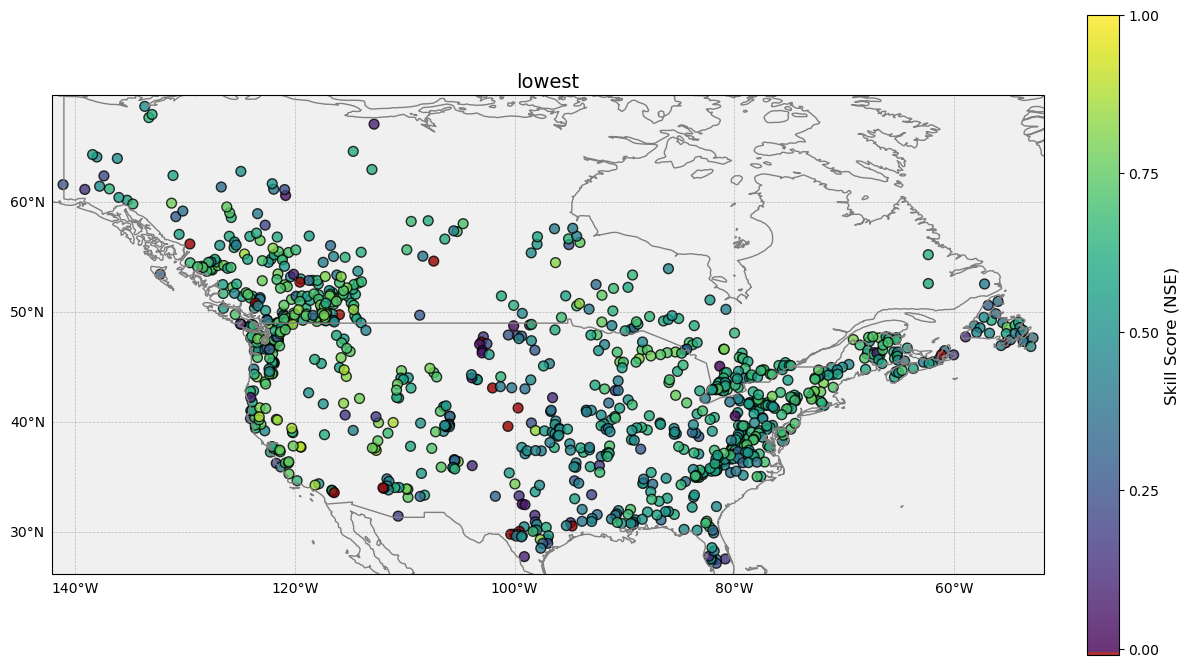

In [5]:
# Fixed colorbar limits
vmin, vmax = 0, 1

# Create colormap: dark red for negative values, viridis for 0-1
viridis = plt.cm.viridis
cmap_array = viridis(np.linspace(0, 1, 256))
# Prepend dark red for negative values
neg_color = np.array([[0.6, 0, 0, 1]])  # dark red RGBA
cmap = ListedColormap(np.vstack([neg_color, cmap_array]))

for benchmark, df_plot in plot_dfs.items():
    fig, ax = plt.subplots(
        1, 1, figsize=(12, 12), 
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Map extent
    lon_min, lon_max = df_plot['longitude'].min() - 1, df_plot['longitude'].max() + 1
    lat_min, lat_max = df_plot['latitude'].min() - 1, df_plot['latitude'].max() + 1
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Map background
    ax.set_facecolor('#f0f0f0')
    ax.add_feature(cfeature.BORDERS, edgecolor='grey', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=1)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Assign colors: negative values map to -0.01 to pick the dark red
    colors = np.where(df_plot['skill_score'] < 0, -0.01, df_plot['skill_score'])

    # Scatter plot
    sc = ax.scatter(
        df_plot['longitude'], df_plot['latitude'],
        c=colors,
        cmap=cmap,
        s=50,
        edgecolor='k',
        alpha=0.8,
        norm=Normalize(vmin=-0.01, vmax=1),  # -0.01 = dark red, 0→1 = viridis
        transform=ccrs.PlateCarree()
    )

    ax.set_title(benchmark, fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Colorbar: show 0→1 only
    cbar = fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Skill Score (NSE)', fontsize=12)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.tight_layout()
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_{benchmark}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{plot_prefix}_{period}_skill_{benchmark}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

### CDF

CDF plot saved to: ./camels-spat/plots//nse_calibration_cdf.pdf


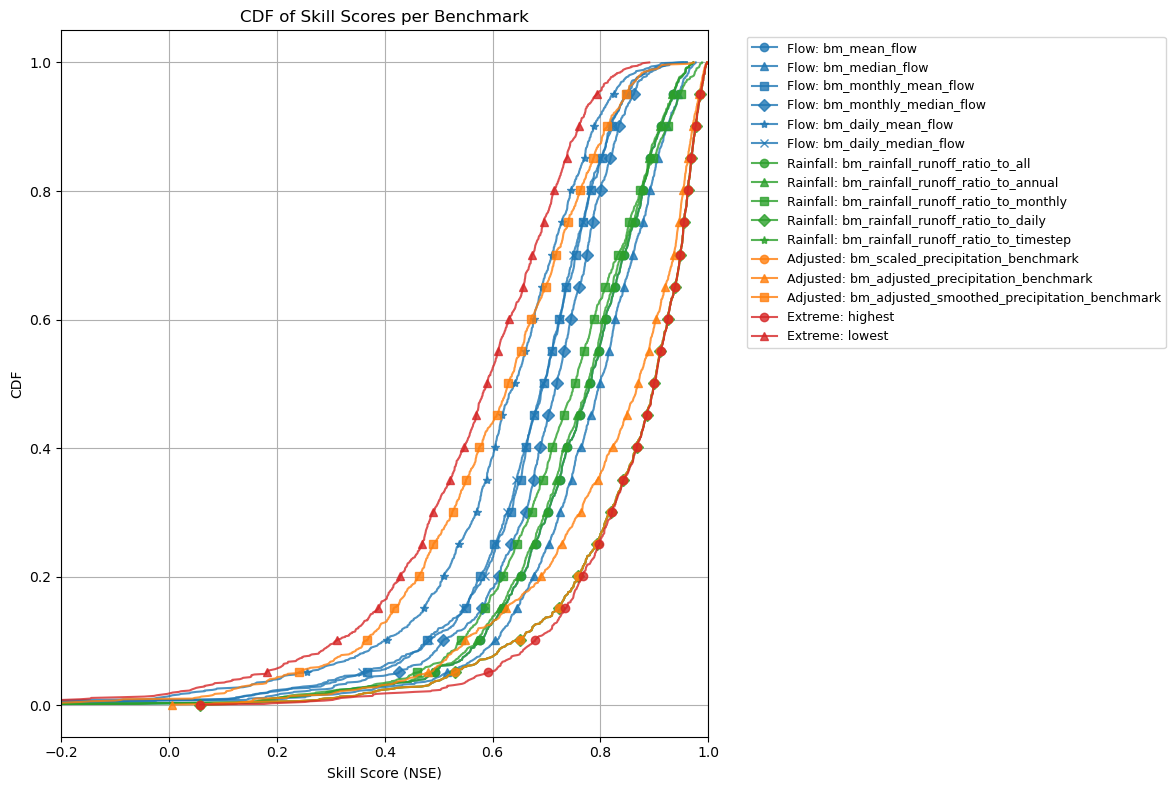

In [6]:
# Define categories
categories = {
    'Flow': [
        "bm_mean_flow", "bm_median_flow",
        "bm_monthly_mean_flow", "bm_monthly_median_flow",
        "bm_daily_mean_flow", "bm_daily_median_flow"
    ],
    'Rainfall': [
        "bm_rainfall_runoff_ratio_to_all",
        "bm_rainfall_runoff_ratio_to_annual",
        "bm_rainfall_runoff_ratio_to_monthly",
        "bm_rainfall_runoff_ratio_to_daily",
        "bm_rainfall_runoff_ratio_to_timestep"
    ],
    'Adjusted': [
        "bm_scaled_precipitation_benchmark",
        "bm_adjusted_precipitation_benchmark",
        "bm_adjusted_smoothed_precipitation_benchmark"
    ],
    'Extreme': ['highest', 'lowest']
}

# Assign colors for categories
colors = {
    'Flow': 'tab:blue',
    'Rainfall': 'tab:green',
    'Adjusted': 'tab:orange',
    'Extreme': 'tab:red'
}
# Define a set of markers to cycle through
markers = ['o', '^', 's', 'D', '*', 'x', 'v', '+', 'p', 'h']

plt.figure(figsize=(12, 8))

for cat, benchmarks in categories.items():
    for i, benchmark in enumerate(benchmarks):
        if benchmark in plot_dfs:
            scores = plot_dfs[benchmark]['skill_score'].dropna().sort_values()
            cdf = np.arange(1, len(scores)+1) / len(scores)
            
            # Cycle markers
            marker = markers[i % len(markers)]
            
            # Label includes category + benchmark
            label = f"{cat}: {benchmark}"
            
            plt.plot(
                scores, cdf,
                label=label,
                color=colors[cat],
                marker=marker,
                markevery=max(1, len(scores)//20),  # spread markers along the line
                alpha=0.8
            )

plt.xlabel('Skill Score (NSE)')
plt.ylabel('CDF')
plt.title('CDF of Skill Scores per Benchmark')
plt.xlim(-0.2, 1)
plt.grid(True)

# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
# Save figure
plt.savefig(f'{output_dir}/{plot_prefix}_{period}_cdf.png', dpi=300, bbox_inches='tight')

# Save figure as PDF
output_file_pdf = f'{output_dir}/{plot_prefix}_{period}_cdf.pdf'
plt.savefig(output_file_pdf, dpi=300, bbox_inches='tight')
print(f"CDF plot saved to: {output_file_pdf}")

plt.show()

### Statistics

In [7]:
# 1. Per-benchmark stats
stats_df = pd.DataFrame(columns=['benchmark','mean','median','std','iqr','min','max'])
for benchmark, df in plot_dfs.items():
    scores = df['skill_score'].dropna()
    stats_df = pd.concat([
        stats_df,
        pd.DataFrame([{
            'benchmark': benchmark,
            'mean': scores.mean(),
            'median': scores.median(),
            'std': scores.std(),
            'iqr': scores.quantile(0.75) - scores.quantile(0.25),
            'min': scores.min(),
            'max': scores.max()
        }])
    ], ignore_index=True)

# 2. Per-group stats
group_stats = pd.DataFrame(columns=['group','mean','median','std','iqr','min','max'])
for group, benchmarks in categories.items():
    # collect all scores in this group
    all_scores = pd.concat([plot_dfs[b]['skill_score'].dropna() for b in benchmarks if b in plot_dfs])
    if len(all_scores) > 0:
        group_stats = pd.concat([
            group_stats,
            pd.DataFrame([{
                'group': group,
                'mean': all_scores.mean(),
                'median': all_scores.median(),
                'std': all_scores.std(),
                'iqr': all_scores.quantile(0.75) - all_scores.quantile(0.25),
                'min': all_scores.min(),
                'max': all_scores.max()
            }])
        ], ignore_index=True)



/tmp/ipykernel_2860070/663856267.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat([
/tmp/ipykernel_2860070/663856267.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_stats = pd.concat([


In [8]:
stats_df

benchmark      mean    median  \
0                                   bm_mean_flow  0.751892  0.781212   
1                                 bm_median_flow  0.771371  0.799376   
2                           bm_monthly_mean_flow  0.662320  0.695690   
3                         bm_monthly_median_flow  0.687654  0.719078   
4                             bm_daily_mean_flow  0.603954  0.641216   
5                           bm_daily_median_flow  0.660697  0.694216   
6                bm_rainfall_runoff_ratio_to_all  0.751921  0.781212   
7             bm_rainfall_runoff_ratio_to_annual  0.747338  0.777459   
8            bm_rainfall_runoff_ratio_to_monthly  0.733076  0.753048   
9              bm_rainfall_runoff_ratio_to_daily  0.848102  0.899316   
10          bm_rainfall_runoff_ratio_to_timestep  0.848102  0.899316   
11             bm_scaled_precipitation_benchmark  0.848102  0.899316   
12           bm_adjusted_precipitation_benchmark  0.811242  0.870746   
13  bm_adjusted_smoothed_precipitation_benchmark  0.595721  0.629059   
14                                       highest  0.856083  0.899652   
15                                        lowest  0.549756  0.590007   

         std       iqr       min       max  
0   0.157648  0.183905 -0.876262  0.972509  
1   0.151834  0.173728 -0.745167  0.976927  
2   0.189720  0.165321 -2.206518  0.958263  
3   0.178888  0.151277 -2.063842  0.960740  
4   0.229943  0.190400 -3.235883  0.953138  
5   0.200010  0.160164 -2.778337  0.960647  
6   0.157652  0.183905 -0.876262  0.972509  
7   0.159274  0.186251 -0.913063  0.972269  
8   0.171165  0.207312 -1.289528  0.988906  
9   0.151385  0.161429  0.057458  0.998143  
10  0.151385  0.161429  0.057458  0.998143  
11  0.151385  0.161429  0.057458  0.998143  
12  0.174910  0.217211  0.004411  0.998052  
13  0.224407  0.249926 -2.257422  0.973693  
14  0.137176  0.157035  0.057458  0.998143  
15  0.247661  0.225081 -3.235883  0.890768

In [9]:
group_stats

group      mean    median       std       iqr       min       max
0      Flow  0.689648  0.718807  0.194973  0.181276 -3.235883  0.976927
1  Rainfall  0.785708  0.814500  0.166387  0.207678 -1.289528  0.998143
2  Adjusted  0.751688  0.800586  0.216778  0.294652 -2.257422  0.998143
3   Extreme  0.702920  0.736372  0.252046  0.329047 -3.235883  0.998143

In [10]:
# Ensure highest and lowest exist
if 'highest' in plot_dfs and 'lowest' in plot_dfs:
    # Get scores
    high_scores = plot_dfs['highest']['skill_score'].dropna().sort_values()
    low_scores = plot_dfs['lowest']['skill_score'].dropna().sort_values()
    
    # Compute CDFs
    high_cdf = np.arange(1, len(high_scores)+1) / len(high_scores)
    low_cdf = np.arange(1, len(low_scores)+1) / len(low_scores)
    
    # Find CDF value at skill_score = 0
    # Use searchsorted to find the index where score >= 0
    idx_high = np.searchsorted(high_scores, 0)
    idx_low = np.searchsorted(low_scores, 0)
    
    # Probability that score <= 0
    prob_high = high_cdf[idx_high] if idx_high < len(high_cdf) else 1.0
    prob_low = low_cdf[idx_low] if idx_low < len(low_cdf) else 1.0
    
    diff_prob = prob_high - prob_low
    
    print(f"Probability (skill <= 0) for 'highest': {prob_high:.2f}")
    print(f"Probability (skill <= 0) for 'lowest': {prob_low:.2f}")
    print(f"Difference in probability: {diff_prob:.2f}")
else:
    print("Highest or lowest benchmark missing in plot_dfs")

Probability (skill <= 0) for 'highest': 0.00
Probability (skill <= 0) for 'lowest': 0.02
Difference in probability: -0.02
